# EmployeePayHistory

## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from urllib import parse
from sqlalchemy.exc import OperationalError
from common_filters import drop_sk_datetime_added_columns as drop_columns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Connecting to the database
Connecting to the UnitedOutdoors sql server database and reading the data from the EmployeePayHistory table

In [2]:
DB = {
    'servername' : '(local)\\SQLEXPRESS',
    'united_outdoors_database' : 'UnitedOutdoors',
}

In [3]:
params = parse.quote_plus(f'DRIVER={{SQL Server}};SERVER={DB["servername"]};DATABASE={DB["united_outdoors_database"]};Trusted_Connection=yes')
engine = create_engine(f'mssql+pyodbc:///?odbc_connect={params}', use_setinputsizes=False, connect_args={'options': '-c search_path=dbo'}, fast_executemany=True) # setinputsizes needs to be turned off for sql server, idk why but gives errors otherwise
try:
    establish_conn = engine.connect()
    print(f'Connection to {DB["united_outdoors_database"]} database successful')
except OperationalError as e:
    print(f'Error: {e}')

Connection to UnitedOutdoors database successful


## Reading in the data

In [4]:
def read_data(sql_query):
    connection = engine.connect()
    try:
        df = pd.read_sql(sql_query, connection)
        return df
    except OperationalError as e:
        print(f'Error: {e}')
    finally:
        connection.close()
    return None

In [5]:
sql_query_employeepayhistory = "SELECT * FROM EmployeePayHistory"
employeepayhistory_df = read_data(sql_query_employeepayhistory)

employeepayhistory_df.head()

,EMPLOYEEPAYHISTORY_sk,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_BusinessEntityID,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_PayFrequency,EMPLOYEEPAYHISTORY_datetime_added
0,1,910,2009-01-14,125.5000,2,2024-05-21 07:52:34.377
1,2,1510,2008-01-31,63.4615,2,2024-05-21 07:52:34.377
2,3,912,2007-11-11,43.2692,2,2024-05-21 07:52:34.377
3,4,1810,2007-12-05,8.6200,2,2024-05-21 07:52:34.377
4,5,1810,2010-05-31,23.7200,2,2024-05-21 07:52:34.377


In [6]:
sql_query_businessentity = "SELECT * FROM BusinessEntity"
businessentity_df = read_data(sql_query_businessentity)

businessentity_df.head()

,BUSINESSENTITY_sk,BUSINESSENTITY_BUSINESSENTITY_BusinessEntityID,BUSINESSENTITY_BUSINESSENTITYCONTACT_PersonID,BUSINESSENTITY_CONTACTTYPE_ContactTypeID,BUSINESSENTITY_CONTACTTYPE_Name,BUSINESSENTITY_datetime_added
0,1,NaN,NaN,1.0,Accounting Manager,2024-05-21 07:50:10.353
1,2,1510.0,1509.0,2.0,Assistant Sales Agent,2024-05-21 07:50:10.353
2,3,1518.0,1517.0,2.0,Assistant Sales Agent,2024-05-21 07:50:10.353
3,4,1522.0,1521.0,2.0,Assistant Sales Agent,2024-05-21 07:50:10.353
4,5,1528.0,1527.0,2.0,Assistant Sales Agent,2024-05-21 07:50:10.353


## Data Cleaning

In [7]:
# combining the two dataframes
employeepayhistory_df = employeepayhistory_df.merge(businessentity_df, left_on='EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_BusinessEntityID', right_on='BUSINESSENTITY_sk', how='left')

# dropping the datetime_added and sk columns
drop_columns(employeepayhistory_df)

In [8]:
# dropping unnecessary columns
columns_to_drop = ['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_BusinessEntityID', 'BUSINESSENTITY_BUSINESSENTITYCONTACT_PersonID', 'BUSINESSENTITY_CONTACTTYPE_Name']

employeepayhistory_df.drop(columns=columns_to_drop, inplace=True)

In [9]:
# replacing the NaN and Null values with 0
employeepayhistory_df.fillna(0, inplace=True)

# converting the columns
employeepayhistory_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate'] = employeepayhistory_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate'].astype(float)
employeepayhistory_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_PayFrequency'] = employeepayhistory_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_PayFrequency'].astype(int)
employeepayhistory_df['BUSINESSENTITY_BUSINESSENTITY_BusinessEntityID'] = employeepayhistory_df['BUSINESSENTITY_BUSINESSENTITY_BusinessEntityID'].astype(int)
employeepayhistory_df['BUSINESSENTITY_CONTACTTYPE_ContactTypeID'] = employeepayhistory_df['BUSINESSENTITY_CONTACTTYPE_ContactTypeID'].astype(int)

# Ensure the date column is in datetime format
employeepayhistory_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate'] = pd.to_datetime(employeepayhistory_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate'])

# Convert the datetime column to number of days since Unix epoch
employeepayhistory_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate'] = (employeepayhistory_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')

In [10]:
# checking for any null values
employeepayhistory_df.isnull().sum()

EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate    0
EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate              0
EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_PayFrequency      0
BUSINESSENTITY_BUSINESSENTITY_BusinessEntityID          0
BUSINESSENTITY_CONTACTTYPE_ContactTypeID                0
dtype: int64

In [11]:
employeepayhistory_df.head()

,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_PayFrequency,BUSINESSENTITY_BUSINESSENTITY_BusinessEntityID,BUSINESSENTITY_CONTACTTYPE_ContactTypeID
0,14258,125.5000,2,1648,19
1,13909,63.4615,2,885,0
2,13828,43.2692,2,1658,19
3,13852,8.6200,2,1485,0
4,14760,23.7200,2,1485,0


## Data Analysis
Predicting the rate of pay for employees based on the other columns, using a variety of models

### Splitting the data

In [12]:
# splitting the data
X = employeepayhistory_df.drop(columns=['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate'])
y = employeepayhistory_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression

In [13]:
# scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# fitting the model
model = LinearRegression()

model.fit(X_train_scaled, y_train)

LinearRegression()

In [15]:
# predicting the values
y_pred = model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [16]:
# calculating the metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

Mean Squared Error: 34.133233735410684
R2 Score: 0.47814117939648226


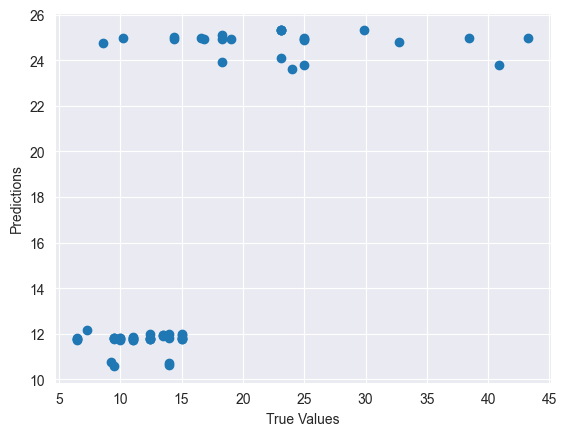

In [17]:
# visualizing the results
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [18]:
# dataframe with the predictions and the actual values, plus other metrics
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results['Difference'] = results['Actual'] - results['Predicted']
results['Absolute Difference'] = np.abs(results['Difference'])
results['Squared Difference'] = results['Difference'] ** 2

results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
173,9.50,10.594862,-1.094862,1.094862,1.198723
33,12.45,11.785862,0.664138,0.664138,0.441080
165,10.00,11.767898,-1.767898,1.767898,3.125463
78,9.50,11.834928,-2.334928,2.334928,5.451887
93,13.45,11.933713,1.516287,1.516287,2.299128
...,...,...,...,...,...
132,15.00,11.818048,3.181952,3.181952,10.124820
253,9.25,10.757127,-1.507127,1.507127,2.271433
175,6.50,11.762340,-5.262340,5.262340,27.692223
225,10.00,11.752782,-1.752782,1.752782,3.072245


### Decision Tree Regressor